In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = pd.concat([df_train, df_test], axis = 0)

First of all, we examine the dataset for missing values. We print out each column to get a feel for the incompleteness of the data.

In [2]:
print('Missing values per column:')
missing = pd.DataFrame()
for c in range(df_full.shape[1]):
    missing_count = df_full.iloc[:, c].shape[0] - df_full.iloc[:, c].count()  
    if missing_count > 0:
        print(f'{c}:\t{df_full.columns[c]}'
              f' - Missing: {missing_count}'
              f' - # Unique values: {len(df_full.iloc[:, c].value_counts())}')

Missing values per column:
3:	Alley - Missing: 2721 - # Unique values: 2
6:	BsmtCond - Missing: 82 - # Unique values: 4
7:	BsmtExposure - Missing: 82 - # Unique values: 4
8:	BsmtFinSF1 - Missing: 1 - # Unique values: 991
9:	BsmtFinSF2 - Missing: 1 - # Unique values: 272
10:	BsmtFinType1 - Missing: 79 - # Unique values: 6
11:	BsmtFinType2 - Missing: 80 - # Unique values: 6
12:	BsmtFullBath - Missing: 2 - # Unique values: 4
13:	BsmtHalfBath - Missing: 2 - # Unique values: 3
14:	BsmtQual - Missing: 81 - # Unique values: 4
15:	BsmtUnfSF - Missing: 1 - # Unique values: 1135
19:	Electrical - Missing: 1 - # Unique values: 5
23:	Exterior1st - Missing: 1 - # Unique values: 15
24:	Exterior2nd - Missing: 1 - # Unique values: 16
25:	Fence - Missing: 2348 - # Unique values: 4
26:	FireplaceQu - Missing: 1420 - # Unique values: 5
30:	Functional - Missing: 2 - # Unique values: 7
31:	GarageArea - Missing: 1 - # Unique values: 603
32:	GarageCars - Missing: 1 - # Unique values: 6
33:	GarageCond - Missing

There exists a lot of missing values. However, reading the data description, it's clear that the data is very clean and that the missing values are real values not incomplete data. We replace all np.nan values with a placeholder below. The placeholder is 'None' for discrete features or zero for continuous features. We also store the names of continuous and discrete features in order to plot them.

In [3]:
missing_label = 'None'
cont_feature = []
disc_feature = []
for c in range(df_full.shape[1]):
    if len(pd.value_counts(df_full.iloc[:, c])) > 15 and df_full.iloc[:, c].values.dtype != 'object':
        if df_full.columns[c] not in ('SalePrice', 'Id'):
            df_full.iloc[:, c].fillna(0, inplace = True)
            cont_feature.append(df_full.columns[c])
    else:
        df_full.iloc[:, c].fillna(missing_label, inplace = True)
        disc_feature.append(df_full.columns[c])

Now we examine our response by plotting its histogram and QQ-plot.

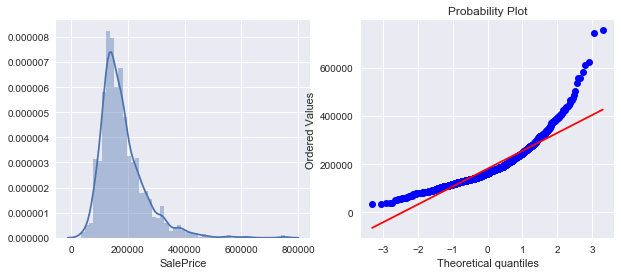

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(df_train['SalePrice'], ax = ax[0])
stats.probplot(df_train['SalePrice'], plot = ax[1])
plt.show()

We can see from the histogram that our response exhibits positive skewness and positive kurtosis. We attempt to correct for that by applying a square root transformation.

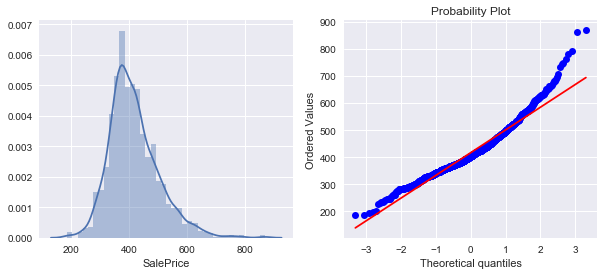

In [5]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(np.sqrt(df_train['SalePrice']), ax = ax[0])
stats.probplot(np.sqrt(df_train['SalePrice']), plot = ax[1])
plt.show()

The data still exhibits some skewness and kurtosis. We now instead apply a natural log transformation.

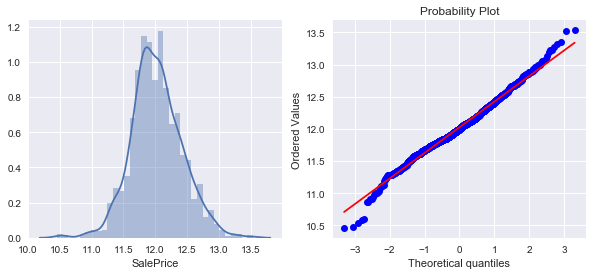

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(np.log(df_train['SalePrice']), ax = ax[0])
stats.probplot(np.log(df_train['SalePrice']), plot = ax[1])
plt.show()

The data is now approximately normal.

In [7]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_full['SalePrice'] = np.log(df_full['SalePrice'])

We then visualize the relation between each continuous feature and the target variable in order to get a better feel for the data.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


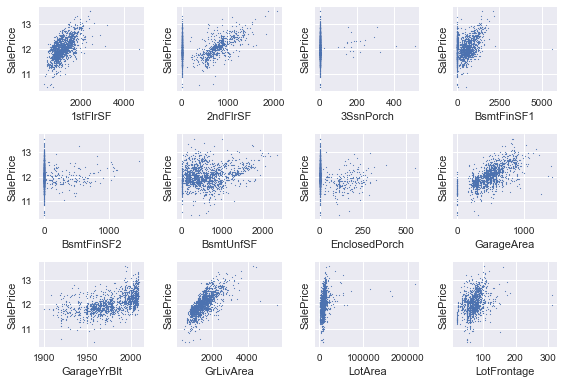

In [8]:
plt.ion()
i = 0
while i < len(cont_feature):
    fig, axs = plt.subplots(nrows = 3,
                            ncols= 4,
                            sharey = 'row')
    axs = axs.flatten()
    for ax in axs:
        if i >= len(cont_feature): break
        ax.scatter(x = df_train[cont_feature[i]],
                   y = df_train['SalePrice'],
                   s = 3, marker = '.')
        ax.set_xlabel(cont_feature[i])
        ax.set_ylabel('SalePrice')
        i += 1
    fig.tight_layout()
    fig.show()

We can see from the graphs that most continuous features can be well approximated by a linear function. Features that represent years can be even better approximated with a linear function after applying a transformation. We do the same for discrete features, plotting them in box plots to get a better feel for the data. We also convert the labels to numeric ordinal values. In addition, we move the MSSubClass feature to the discrete columns to sort it into ordinal values.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


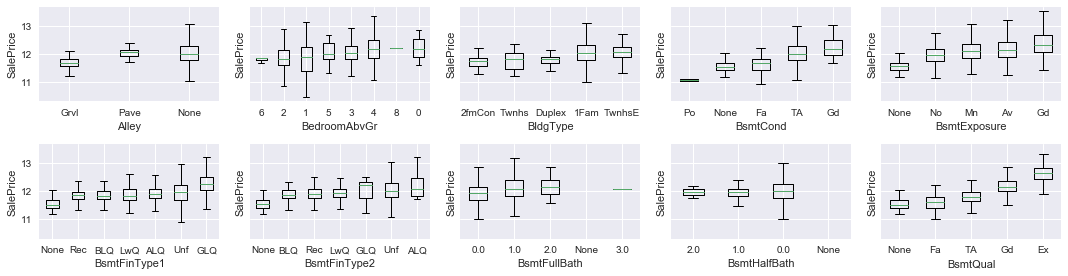

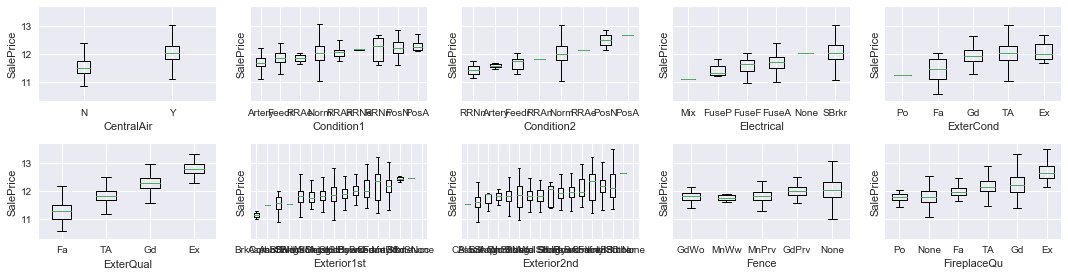

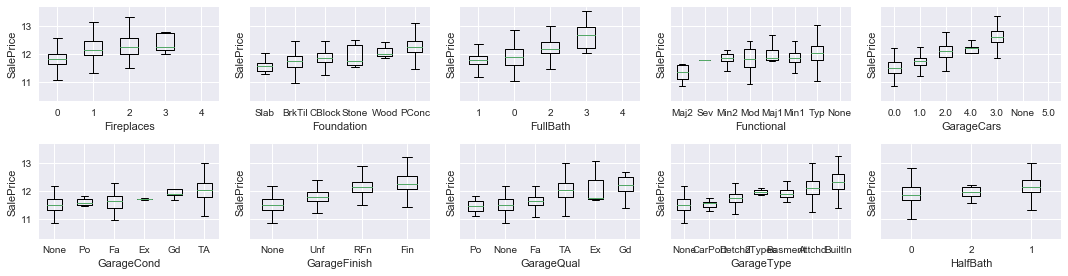

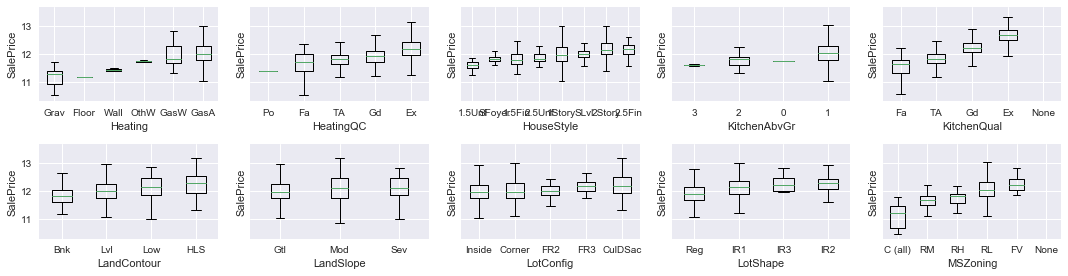

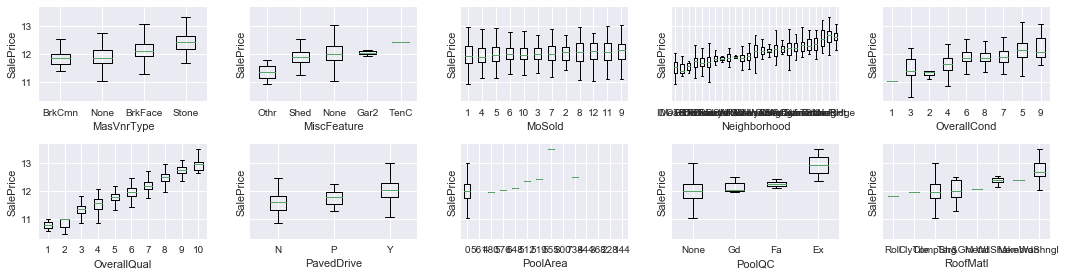

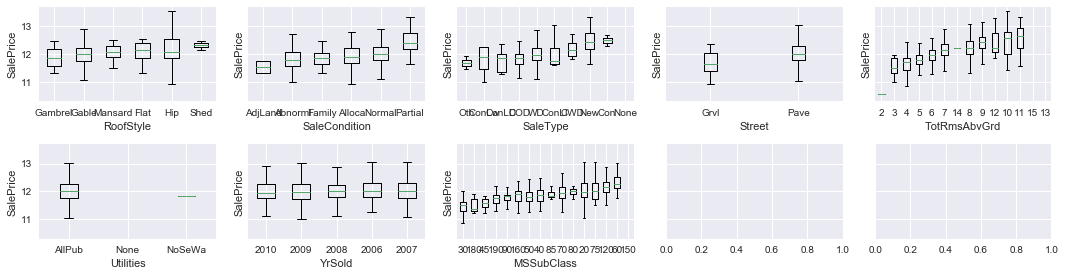

In [9]:
cont_feature.remove('MSSubClass')
disc_feature.append('MSSubClass')
i = 0
while i < len(disc_feature):
    fig, axs = plt.subplots(nrows = 2,
                            ncols= 5,
                            sharey = 'row',
                            figsize = (12, 4))
    axs = axs.flatten()
    for ax in axs:
        if i >= len(disc_feature): break
        categories = df_full[disc_feature[i]].value_counts().index.tolist()
        categories.sort(key = lambda x: df_full['SalePrice'][df_full[disc_feature[i]] == x].mean())
        t = df_full.iloc[:df_train.shape[0], :]
        boxes = [t['SalePrice'][t[disc_feature[i]] == category] for category in categories]
        ax.boxplot(boxes, labels=categories)
        ax.set_xlabel(disc_feature[i])
        ax.set_ylabel('SalePrice')
        
        # Transforming labels into ordinal values sorted according to mean (from above).
        categories = dict(zip(categories, range(len(categories))))
        df_full[disc_feature[i]] = df_full[disc_feature[i]].apply(lambda x: categories[x])
        i += 1
        
    fig.tight_layout()
    fig.show()

Once again, it appears that most features can be modelled with a linear function. We can conclude that a linear model will do well on this data, but we'll try different methods as well just to be sure. We standardize the data and prepare to initially model it without reducing its dimensionality to see how well it will do in its 'default' state.

In [10]:
random_seed = 4057585448 # Random seed for reproducibility.

df_train = df_full.iloc[:df_train.shape[0], :]
df_test = df_full.iloc[df_train.shape[0]:, :]

X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

We then test our default model and fit it with a Random Forest. Also, to get a reference for how well our model is doing, we calculate the train error we get if we simply predict the mean for each value in target variable. 

In [12]:
print(math.sqrt(mean_squared_error(y_train, np.mean(y_train) * np.ones(y_train.shape))))

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-rf_gs.best_score_)}')
print(rf_gs.best_params_)

0.39931504624370256
Grid searching RF model... 


Best score is 0.13902371407979378
{'max_depth': 18}


<p>Not bad, but we can do better.</p>

<p>Let's try to reduce our data's dimensionality. First, we plot a PCA scree plot to see how well we can do by simply projecting our data to a lower dimension.</p>

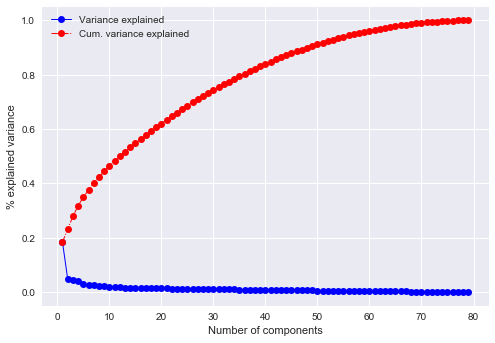

In [13]:
pca = PCA(random_state = random_seed)
pca.fit(X_train)

plt.plot(range(1, X_train.shape[1] + 1),
         pca.explained_variance_ratio_,
         lw=1, color='blue',
         label='Variance explained',
         marker = 'o')
plt.plot(range(1, X_train.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_),
         lw=1, color='red',
         ls='-.', marker = 'o',
         label='Cum. variance explained')
plt.xlabel('Number of components')
plt.ylabel('% explained variance')
plt.legend(loc = 'upper left')
plt.show()

<p>Due to the smoothness of the scree plot, we cannot use PCA to reduce our data's dimensionality (unless we simply use only the first component, ignoring over 80% of the information in our data).</p>

<p>To manually discard useless features, we compute the standard deviation of each feature and print them in a descending order to see which features have very low variability compared to others.</p>

In [14]:
print("Std. for each feature: ")
stds = [(c, df_train.columns[c], df_train.iloc[:, c].std()) for c in range(df_train.shape[1])]
stds.sort(key = lambda x: x[2], reverse = True)
for s in stds:
    print(f'{s[0]}:\t{s[1]}: {s[2]}')

Std. for each feature: 
48:	LotArea: 9981.264932379147
38:	GrLivArea: 525.4803834232027
58:	MiscVal: 496.1230244579311
8:	BsmtFinSF1: 456.09809084092456
37:	GarageYrBlt: 453.6972953893971
15:	BsmtUnfSF: 441.8669552924342
75:	TotalBsmtSF: 438.7053244594705
1:	2ndFlrSF: 436.5284358862591
43:	Id: 421.6100093688479
0:	1stFlrSF: 386.5877380410738
31:	GarageArea: 213.80484145338076
55:	MasVnrArea: 180.73137335812217
9:	BsmtFinSF2: 161.31927280654057
77:	WoodDeckSF: 125.33879435172359
61:	OpenPorchSF: 66.25602767664974
20:	EnclosedPorch: 61.11914860172879
72:	ScreenPorch: 55.757415281874486
52:	LowQualFinSF: 48.623081433519125
50:	LotFrontage: 34.66430423090894
78:	YearBuilt: 30.202904042525265
2:	3SsnPorch: 29.317330556782203
79:	YearRemodAdd: 20.645406807709396
60:	Neighborhood: 6.4096769654039525
53:	MSSubClass: 3.878303572960169
24:	Exterior2nd: 3.537771491876399
23:	Exterior1st: 3.0887316298603382
59:	MoSold: 3.01777372049292
74:	TotRmsAbvGrd: 2.031429254865582
10:	BsmtFinType1: 1.751054

We discard any feature which has an s.t.d. less than 0.5.

In [15]:
df_train = df_train.drop([s[1] for s in stds if s[2] < 0.5 and s[1] != 'SalePrice'], axis = 1)
df_test = df_test.drop([s[1] for s in stds if s[2] < 0.5 and s[1] != 'SalePrice'], axis = 1)
print(df_train.shape)

(1460, 64)


We display a heatmap to visualize the correlation between each feature.

In [16]:
g = sns.heatmap(df_train.corr('pearson'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
sns.plt.show()

We discard any feature that is heavily correlated with another, or is uncorrelated with any other feature. For example YrSold has low correlation with every other feature, including the target variable. And TotalBsmtSF is heavily correlated with 1stFloorSF, so we discard that too.

In [17]:
df_train = df_train.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)
df_test = df_test.drop(['Exterior2nd', 'FireplaceQu', 'GarageCars', 'YrSold', 'GarageFinish', 'GarageQual', 'GarageYrBlt', 'TotalBsmtSF', 'GrLivArea', 'Fence', 'YrSold'], axis = 1)

We then compute the correlation between the target feature and every other feature to study the importance of each feature in predicting the response.

In [18]:
corr = [(df_train.columns[c], df_train['SalePrice'].corr(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
corr.sort(key = lambda x: x[1], reverse = True)
for c in corr:
    print(c)

('SalePrice', 1.0)
('OverallQual', 0.81718441792168361)
('Neighborhood', 0.74264101051194009)
('ExterQual', 0.67883983486430821)
('KitchenQual', 0.6678930256021659)
('GarageArea', 0.65088755590200709)
('BsmtQual', 0.64771782030627334)
('1stFlrSF', 0.59698104503437399)
('FullBath', 0.5958057071158992)
('YearBuilt', 0.58657024038422667)
('GarageType', 0.57562773587554672)
('YearRemodAdd', 0.56560783259117964)
('MSSubClass', 0.56019529248651756)
('Foundation', 0.55041108280602735)
('TotRmsAbvGrd', 0.52723378995591053)
('Fireplaces', 0.48944942759848564)
('HeatingQC', 0.47376166271420328)
('MasVnrType', 0.43032223131972874)
('MasVnrArea', 0.42677513183636506)
('Exterior1st', 0.4139268920122286)
('MSZoning', 0.41057471665943329)
('BsmtFinType1', 0.39668805321043621)
('OverallCond', 0.38528698974100928)
('GarageCond', 0.37761189422021313)
('BsmtFinSF1', 0.37202307356708814)
('BsmtExposure', 0.35742109703492581)
('SaleType', 0.34222517272393593)
('WoodDeckSF', 0.33413507395751246)
('HalfBath'

We drop every feature that has an absolute correlation of less the 0.25 with that response.

In [19]:
df_train = df_train.drop([c[0] for c in corr if math.fabs(c[1]) < 0.25], axis = 1)
df_test = df_test.drop([c[0] for c in corr if math.fabs(c[1]) < 0.25], axis = 1)

To get rid of outliers in our data, we standardize the data and ditch any observation with a varible with a Z-score of over 4.0 (approximately 0.9999% of the two-sided area under the normal curve).

In [20]:
df_train_std = sc.fit_transform(df_train.copy())
drop_indices = []
for i in range(df_train.shape[0]):
    for j in df_train_std[i, :]:
        if math.fabs(j) > 4.0:
            drop_indices.append(i)
df_train.drop(drop_indices, axis = 0, inplace = True)
print(df_train.shape)

(1379, 37)


Finally, we search for the best model that represents our data.

In [21]:
X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=GradientBoostingRegressor(random_state = random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(5, 20, 1)],
                                   'max_depth': [x for x in range(2, 7)],
                                   'max_features': [x / 10 for x in range(1, 11)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-gb_gs.best_score_)}')
print(gb_gs.best_params_)
print()

print("Grid searching AB model...")
ad_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=AdaBoostRegressor(base_estimator=LinearRegression(),
                                                  random_state=random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(85, 115, 1)]}])
ad_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ad_gs.best_score_)}')
print(ad_gs.best_params_)
print()

print("Grid searching bagging model...")
bag_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=BaggingRegressor(base_estimator = LinearRegression(),
                                                 n_estimators = 25),
                      param_grid=[{'max_features': [x / 100 for x in range(50, 101, 1)]}])
bag_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-bag_gs.best_score_)}')
print(bag_gs.best_params_)
print()

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(1, 1000, 10)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x for x in range(0, 1000, 10)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-rf_gs.best_score_)}')
print(rf_gs.best_params_)

print("Grid searching KNN model... ")
knn_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=KNeighborsRegressor(),
                      param_grid=[{'n_neighbors': [x for x in range(3, 80)],
                                   'weights': ['uniform', 'distance']}])
knn_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-knn_gs.best_score_)}')
print(knn_gs.best_params_)

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10000 for x in range(10, 1000, 1)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10 for x in range(0, 150, 2)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

os.system('rundll32.exe PowrProf.dll,SetSuspendState 0,1,0')

Grid searching GB model...


Best score is 0.12084369346074994
{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.3}

Grid searching AB model...


Best score is 0.12975839222967353
{'learning_rate': 1.0}

Grid searching bagging model...


Best score is 0.12142188229389306
{'max_features': 0.9}

Grid searching lasso model...


Best score is 0.38176358632212726
{'alpha': 1}

Grid searching ridge model...


Best score is 0.12156530468022447
{'alpha': 10}

Grid searching RF model... 


Best score is 0.13325428850609997
{'max_depth': 15}
Grid searching KNN model... 


Best score is 0.15778454483178375
{'n_neighbors': 9, 'weights': 'distance'}
Grid searching lasso model...


Best score is 0.1218812098185807
{'alpha': 0.001}

Grid searching ridge model...


Best score is 0.12156519206106138
{'alpha': 9.4}



NameError: name 'os' is not defined

Evidently, the best model is a gradient boosting model with a learning rate of 0.09, max depth of 4, and max features of 0.3. We search further around these parameters to get an even better model.

In [18]:
print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10000 for x in range(10, 1000, 1)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10 for x in range(0, 150, 2)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=GradientBoostingRegressor(max_depth = 5, random_state = random_seed),
                      param_grid=[{'learning_rate': [x / 1000 for x in range(75, 85, 1)],
                                   'max_features': [x / 100 for x in range(25, 35)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-gb_gs.best_score_)}')
print(gb_gs.best_params_)
print()

Grid searching lasso model...
Fitting 5 folds for each of 990 candidates, totalling 4950 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    4.0s


[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   17.5s


[Parallel(n_jobs=-1)]: Done 1744 tasks      | elapsed:   31.1s


[Parallel(n_jobs=-1)]: Done 3144 tasks      | elapsed:   46.8s


[Parallel(n_jobs=-1)]: Done 4950 out of 4950 | elapsed:  1.1min finished


Best score is -0.014893686519108216
{'alpha': 0.0013}

Grid searching ridge model...
Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    2.0s


Best score is -0.014860658994796012
{'alpha': 9.6}

Grid searching GB model...
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:    6.0s finished


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.7s


[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.3s


[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.9min finished


Best score is -0.015011416062172106
{'learning_rate': 0.082, 'max_features': 0.34}



So now that we know our optimal hyperparameters, we train the model on the full dataset, predict the target using the test data, and output them to a .csv file.

In [16]:
lasso = Lasso(alpha = 0.0013, max_iter = 10**5)
lasso.fit(X_train, y_train)
y_pred = np.exp(lasso.predict(X_test))
output = pd.concat([pd.read_csv('test.csv')['Id'], pd.Series(y_pred)], axis = 1)
output.columns = ['Id', 'SalePrice']
output.to_csv('submissions.csv', index = False)